In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

In [19]:
dataset_ruta = r'C:\Users\guill\OneDrive\Documentos\Python\RedesNeuronales\ProyectoFinalSonidosUrbanos\deteccion_sonidos_urbanos'

## Dataset en tf

In [21]:
# Cargar metadata generado anteriormente
df_mel = pd.read_csv(dataset_ruta + r"\mel_metadata.csv")
df_mel.head()

# Cargar el CSV original del dataset
metadata_path = os.path.join(dataset_ruta, "data", "UrbanSound8K.csv")
df_original = pd.read_csv(metadata_path)

# Crear diccionario {classID: class}
class_dict = dict(zip(df_original["classID"], df_original["class"]))
print("Diccionario de clases:")
print(class_dict)

# Añadir columna con el nombre de clase
df_mel["class_name"] = df_mel["label"].map(class_dict)

df_mel.head()


Diccionario de clases:
{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


,spectrogram,label,class_name
0,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,3,dog_bark
1,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
2,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
3,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
4,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing


In [22]:
df_mel = df_mel.drop(columns=["label"])
df_mel.head()

,spectrogram,class_name
0,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,dog_bark
1,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
2,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
3,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
4,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing


In [23]:
# Crear lista ordenada de clases
class_names = sorted(df_mel["class_name"].unique())
num_classes = len(class_names)

print("Clases:", class_names)
print("Número de clases:", num_classes)

# Conversión de texto → índice entero
string_lookup = tf.keras.layers.StringLookup(vocabulary=class_names, num_oov_indices=0, output_mode="int")

Clases: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Número de clases: 10


In [24]:
train_df, temp_df = train_test_split(
    df_mel, 
    test_size=0.20, 
    random_state=42, 
    stratify=df_mel["class_name"]
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=42, 
    stratify=temp_df["class_name"]
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 6985
Val: 873
Test: 874


In [25]:
# Cargar espectograma
def load_mel_only(path):
    mel = np.load(path.decode("utf-8")).astype(np.float32)
    return mel

In [26]:
# Wrapper para usar en tf.data
def tf_load_mel(path, label_str):

    mel = tf.numpy_function(load_mel_only, [path], tf.float32)
    mel.set_shape((128, 128, 1))

    label_int = string_lookup(label_str)

    return mel, label_int

In [27]:
# ---------------------------
# Creación de tf.data.Dataset
# ---------------------------
batch_size = 16

# TRAIN
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["spectrogram"].values, train_df["class_name"].values)
)
train_ds = train_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# VALIDATION
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["spectrogram"].values, val_df["class_name"].values)
)
val_ds = val_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TEST
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["spectrogram"].values, test_df["class_name"].values)
)
test_ds = test_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [30]:
import tensorflow as tf

def time_mask(mel, max_mask=20):
    # Obtenemos dimensiones dinámicas
    f = tf.shape(mel)[0]
    t = tf.shape(mel)[1]
    c = tf.shape(mel)[2]

    # Aseguramos que el tamaño de la máscara no exceda el tiempo total
    mask_size = tf.random.uniform([], 0, max_mask, dtype=tf.int32)
    mask_size = tf.minimum(mask_size, t)
    
    # Prevenimos error si mask_size es igual a t (maxval debe ser > minval)
    # Si t - mask_size es 0, t0 será 0.
    limit = tf.maximum(t - mask_size, 1) 
    t0 = tf.random.uniform([], 0, limit, dtype=tf.int32)
    
    # En caso de que t - mask_size fuera 0, forzamos t0 a 0
    t0 = tf.where(t - mask_size <= 0, 0, t0)

    # Creamos la máscara
    mask = tf.ones([f, mask_size, c], dtype=mel.dtype)
    
    # Padding para ubicar la máscara en el tiempo correcto
    # Pad: [Arriba/Abajo (freq)], [Izq/Der (tiempo)], [Canal]
    pad_left = t0
    pad_right = t - t0 - mask_size
    mask = tf.pad(mask, [[0, 0], [pad_left, pad_right], [0, 0]], constant_values=0)
    
    return mel * (1 - mask)

def freq_mask(mel, max_mask=20):
    f = tf.shape(mel)[0]
    t = tf.shape(mel)[1]
    c = tf.shape(mel)[2]

    mask_size = tf.random.uniform([], 0, max_mask, dtype=tf.int32)
    mask_size = tf.minimum(mask_size, f)
    
    limit = tf.maximum(f - mask_size, 1)
    f0 = tf.random.uniform([], 0, limit, dtype=tf.int32)
    f0 = tf.where(f - mask_size <= 0, 0, f0)

    mask = tf.ones([mask_size, t, c], dtype=mel.dtype)
    
    pad_top = f0
    pad_bottom = f - f0 - mask_size
    mask = tf.pad(mask, [[pad_top, pad_bottom], [0, 0], [0, 0]], constant_values=0)
    
    return mel * (1 - mask)

def random_gain(mel, min_gain=0.8, max_gain=1.2):
    gain = tf.random.uniform([], min_gain, max_gain, dtype=tf.float32)
    return mel * gain

def time_shift(mel, max_shift=10):
    # Generar un ESCALAR (shape=[]) es crucial para evitar broadcasting de canales
    shift = tf.random.uniform([], -max_shift, max_shift, dtype=tf.int32)
    
    # axis=1 es el eje del tiempo (width)
    return tf.roll(mel, shift=shift, axis=1)

def augment_mel(mel, label):
    # 1. Definir la forma esperada explícitamente (128, 128, 1)
    # Esto ayuda a TF a no "perderse" en el grafo
    input_shape = [128, 128, 1] 
    mel.set_shape(input_shape)
    
    # Aplicar aumentos
    # Nota: El orden a veces importa, shift al final suele ser más seguro visualmente
    mel = time_mask(mel, max_mask=15)
    mel = freq_mask(mel, max_mask=15)
    mel = random_gain(mel)
    mel = time_shift(mel, max_shift=8)

    # 2. LA SOLUCIÓN AL ERROR: Reshape explícito.
    # Si alguna operación anterior expandió el canal 1 a 128, esto lo colapsa o corrige.
    mel = tf.reshape(mel, input_shape)
    
    # 3. Ensure shape como validación final
    mel = tf.ensure_shape(mel, input_shape)
    
    return mel, label

In [33]:
# Aplicamos el data augmentation
# Corrección: Deshacer lotes -> Aumentar datos -> Volver a hacer lotes

# 1. Quitamos la dimensión del batch temporalmente
train_ds = train_ds.unbatch()

# 2. Aplicamos el aumento (ahora sí recibirá 3 dimensiones)
train_ds = train_ds.map(augment_mel, num_parallel_calls=tf.data.AUTOTUNE)

# 3. Volvemos a agrupar en lotes (usa el tamaño de batch que tenías antes, ej: 32 o 64)
BATCH_SIZE = 32  # Asegúrate de usar el mismo valor que definiste antes
train_ds = train_ds.batch(BATCH_SIZE)

# 4. Prefetch final
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [38]:
import os

# --- CORRECCIÓN ---
# Según tu imagen, la columna original se llama 'spectrogram'
nombre_columna = 'spectrogram' 

# Definimos la carpeta real donde están los archivos ahora
ruta_espectrogramas = os.path.join(dataset_ruta, "espectrogramas")

def corregir_ruta(path_antiguo):
    try:
        # Extraemos solo el nombre del archivo (ej: 1323-5-0.npy)
        nombre_archivo = os.path.basename(str(path_antiguo))
        # Lo unimos con la ruta correcta actual en tu disco C:
        return os.path.join(ruta_espectrogramas, nombre_archivo)
    except Exception as e:
        return path_antiguo

if nombre_columna in df_mel.columns:
    print(f"Ruta original (ejemplo): {df_mel[nombre_columna].iloc[0]}")
    
    # IMPORTANTE: Creamos la columna 'mel_path' nueva con los datos corregidos
    # Así tu código siguiente (que busca 'mel_path') funcionará perfecto.
    df_mel['mel_path'] = df_mel[nombre_columna].apply(corregir_ruta)
    
    print(f"Ruta nueva (ejemplo):    {df_mel['mel_path'].iloc[0]}")
    print("\n¡Éxito! Columna 'mel_path' creada y rutas corregidas.")
else:
    print(f"¡Error! No encuentro la columna '{nombre_columna}'.")

Ruta original (ejemplo): D:\Documentos\IPN\6to Semestre\Aprendizaje_profundo\programas\proyecto\espectrogramas\100032-3-0-0.npy
Ruta nueva (ejemplo):    C:\Users\guill\OneDrive\Documentos\Python\RedesNeuronales\ProyectoFinalSonidosUrbanos\deteccion_sonidos_urbanos\espectrogramas\100032-3-0-0.npy

¡Éxito! Columna 'mel_path' creada y rutas corregidas.


Creando columna 'label'...
¡Éxito! Columna 'label' generada correctamente.
                                         spectrogram        class_name  \
0  D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...          dog_bark   
1  D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...  children_playing   
2  D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...  children_playing   
3  D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...  children_playing   
4  D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...  children_playing   

                                            mel_path  label  
0  C:\Users\guill\OneDrive\Documentos\Python\Rede...      3  
1  C:\Users\guill\OneDrive\Documentos\Python\Rede...      2  
2  C:\Users\guill\OneDrive\Documentos\Python\Rede...      2  
3  C:\Users\guill\OneDrive\Documentos\Python\Rede...      2  
4  C:\Users\guill\OneDrive\Documentos\Python\Rede...      2  
¡Datasets recreados con rutas corregidas!
Shape del Batch: (32, 128, 128, 1)


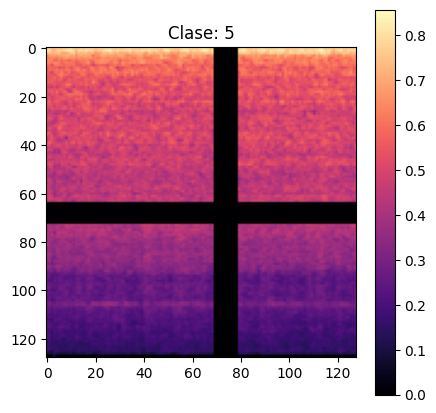

In [41]:
# 1. Definimos el mapa INVERSO (Nombre -> Número)
# Estos son los IDs oficiales de UrbanSound8K
label_map = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9
}

# 2. Creamos la columna 'label' que te falta
# Mapeamos la columna 'class_name' usando el diccionario
if 'label' not in df_mel.columns:
    print("Creando columna 'label'...")
    df_mel['label'] = df_mel['class_name'].map(label_map)
    
# Verificamos que no haya nulos (por si algún nombre no coincidiera)
if df_mel['label'].isnull().any():
    print("¡ALERTA! Hay nombres de clase que no coincidieron con el diccionario.")
    print(df_mel[df_mel['label'].isnull()])
else:
    print("¡Éxito! Columna 'label' generada correctamente.")
    print(df_mel.head())

# --- AHORA SÍ, TU CÓDIGO DE DIVISIÓN FUNCIONARÁ ---
# Copia aquí el bloque grande que te envié antes (el que empieza con train_test_split)

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. DIVIDIR DATOS (Usando la nueva columna 'mel_path' corregida)
train_df, val_df = train_test_split(df_mel, test_size=0.2, stratify=df_mel["label"], random_state=42)

# 2. CREAR DATASETS
# Nota: Aquí usamos 'mel_path' que acabamos de crear/corregir
train_ds = tf.data.Dataset.from_tensor_slices((train_df["mel_path"].values, train_df["label"].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["mel_path"].values, val_df["label"].values))

# 3. DEFINIR CARGA (Asegurándonos de que load_mel_only esté disponible)
def load_mel_only(path, label):
    # Carga el npy
    mel = tf.numpy_function(func=lambda p: np.load(p), inp=[path], Tout=tf.float32)
    # Asegura la forma (128, 128, 1)
    mel.set_shape([128, 128, 1])
    return mel, label

# Aplicar carga
train_ds = train_ds.map(load_mel_only, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_mel_only, num_parallel_calls=tf.data.AUTOTUNE)

# 4. APLICAR AUMENTO DE DATOS (Pipeline Correcto)
# Importante: Aplicamos augment ANTES del batch para evitar el error de dimensiones
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(augment_mel, num_parallel_calls=tf.data.AUTOTUNE) # Aumento imagen por imagen

# 5. CREAR LOTES (BATCH)
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print("¡Datasets recreados con rutas corregidas!")

# 6. VISUALIZACIÓN (Prueba de fuego)
try:
    mel_batch, label_batch = next(iter(train_ds))
    
    print("Shape del Batch:", mel_batch.shape) # Debería ser (32, 128, 128, 1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(mel_batch[0].numpy().squeeze(), cmap="magma")
    plt.title(f"Clase: {label_batch[0].numpy()}")
    plt.colorbar()
    plt.show()
except Exception as e:
    print(f"Error al visualizar: {e}")

In [42]:
mel_batch, label_batch = next(iter(train_ds))
print("Mín etiqueta:", label_batch.numpy().min())
print("Máx etiqueta:", label_batch.numpy().max())

Mín etiqueta: 0
Máx etiqueta: 9


## Entrenamiento

In [43]:
from tensorflow.keras import layers, models

In [44]:
def build_crnn_model(input_shape=(128,128,1), num_classes=10):

    inputs = layers.Input(shape=input_shape)

    # CNN
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)  # → (16,16,128)

    # TimeDistributed pooling
    x = layers.Permute((2,1,3))(x)  # (batch, time, freq, channels)

    x = layers.TimeDistributed(layers.GlobalAveragePooling1D())(x)
    # → (batch, time=16, features=128)

    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3))(x)

    # Dense
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [45]:
# Creación del modelo
model = build_crnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,290 (786.29 KB)

 Trainable params: 200,842 (784.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [46]:
# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [47]:
# Definición de callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),

    tf.keras.callbacks.ModelCheckpoint(
        "crnn_urbansound8k.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

In [48]:
# -------------------------
# Entrenamiento del modelo
# -------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2139 - loss: 2.1066

219/219 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.2142 - loss: 2.1059 - val_accuracy: 0.1145 - val_loss: 2.7893 - learning_rate: 0.0010
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3736 - loss: 1.6644

219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 235ms/step - accuracy: 0.3738 - loss: 1.6640 - val_accuracy: 0.1151 - val_loss: 2.6674 - learning_rate: 0.0010
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4938 - loss: 1.3827

219/219 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.4939 - loss: 1.3826 - val_accuracy: 0.3434 - val_loss: 1.7456 - learning_rate: 0.0010
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5495 - loss: 1.2184

219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.5496 - loss: 1.2182 - val_accuracy: 0.3841 - val_loss: 1.6420 - learning_rate: 0.0010
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.6118 - loss: 1.0991 - val_accuracy: 0.4150 - val_loss: 1.8083 - learning_rate: 0.0010
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.6548 - loss: 0.9877 - val_accuracy: 0.3967 - val_loss: 2.4186 - learning_rate: 0.0010
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6890 - loss: 0.9036

219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 232ms/step - accuracy: 0.6890 - loss: 0.9035 - val_accuracy: 0.5615 - val_loss: 1.3268 - learning_rate: 0.0010
Epoch 8/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 237ms/step - accuracy: 0.7222 - loss: 0.8389 - val_accuracy: 0.5278 - val_loss: 1.4775 - learning_rate: 0.0010
Epoch 9/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7465 - loss: 0.7481

219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 226ms/step - accuracy: 0.7466 - loss: 0.7480 - val_accuracy: 0.7441 - val_loss: 0.8365 - learning_rate: 0.0010
Epoch 10/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 80s 218ms/step - accuracy: 0.7822 - loss: 0.6838 - val_accuracy: 0.3068 - val_loss: 2.7243 - learning_rate: 0.0010
Epoch 11/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 55s 250ms/step - accuracy: 0.7883 - loss: 0.6509 - val_accuracy: 0.6571 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 12/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.7880 - loss: 0.6559 - val_accuracy: 0.3950 - val_loss: 3.9238 - learning_rate: 0.0010
Epoch 13/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8213 - loss: 0.5517

219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.8213 - loss: 0.5516 - val_accuracy: 0.7676 - val_loss: 0.7138 - learning_rate: 5.0000e-04
Epoch 14/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 201ms/step - accuracy: 0.8454 - loss: 0.4832 - val_accuracy: 0.7378 - val_loss: 0.8607 - learning_rate: 5.0000e-04
Epoch 15/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.8565 - loss: 0.4602 - val_accuracy: 0.7750 - val_loss: 0.7162 - learning_rate: 5.0000e-04
Epoch 16/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 259ms/step - accuracy: 0.8660 - loss: 0.4365 - val_accuracy: 0.5884 - val_loss: 1.3970 - learning_rate: 5.0000e-04
Epoch 17/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8697 - loss: 0.4109

219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.8697 - loss: 0.4108 - val_accuracy: 0.8993 - val_loss: 0.3272 - learning_rate: 2.5000e-04
Epoch 18/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step - accuracy: 0.8827 - loss: 0.3831 - val_accuracy: 0.8128 - val_loss: 0.5744 - learning_rate: 2.5000e-04
Epoch 19/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.8787 - loss: 0.3767 - val_accuracy: 0.8649 - val_loss: 0.4057 - learning_rate: 2.5000e-04
Epoch 20/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 203ms/step - accuracy: 0.8902 - loss: 0.3663 - val_accuracy: 0.8105 - val_loss: 0.6349 - learning_rate: 2.5000e-04
Epoch 21/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 204ms/step - accuracy: 0.8853 - loss: 0.3609 - val_accuracy: 0.8643 - val_loss: 0.4309 - learning_rate: 1.2500e-04
Epoch 22/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.8951 - loss: 0.3323 - val_accuracy: 0.8884 - val_loss: 0.3465 - learning_rate: 1.2500e-04


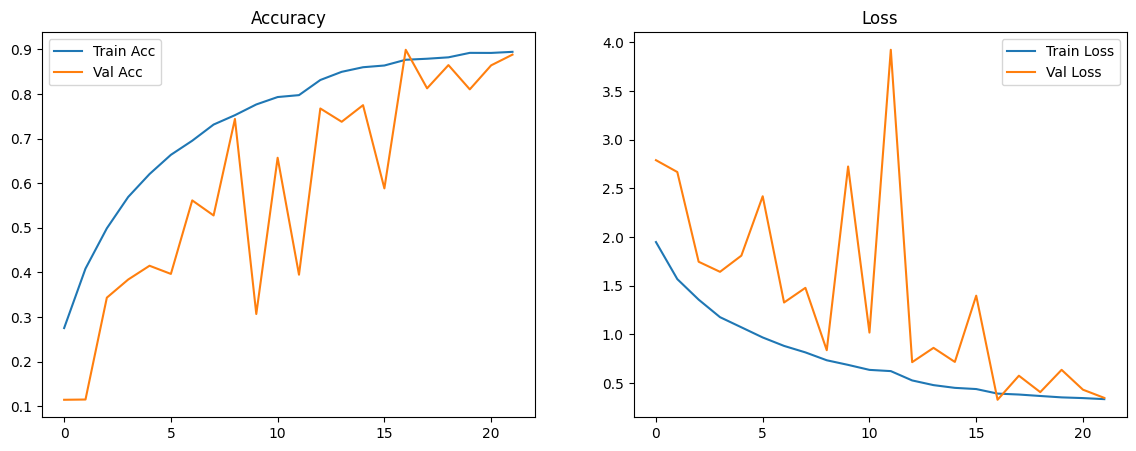

In [49]:

# Graficamos
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [52]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. DEFINIR LAS FUNCIONES NECESARIAS (Para arreglar el NameError) ---
def load_mel_only(path, label):
    # Carga el npy
    mel = tf.numpy_function(func=lambda p: np.load(p), inp=[path], Tout=tf.float32)
    mel.set_shape([128, 128, 1])
    return mel, label

def create_dataset(dataframe, is_training=False):
    # Crear dataset desde el DataFrame corregido
    ds = tf.data.Dataset.from_tensor_slices((dataframe["mel_path"].values, dataframe["label"].values))
    ds = ds.map(load_mel_only, num_parallel_calls=tf.data.AUTOTUNE)
    
    # En test solo cacheamos y hacemos batch (sin data augmentation)
    ds = ds.cache()
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# --- 2. REGENERAR TEST_DS CON RUTAS CORRECTAS ---
# Volvemos a dividir para asegurarnos de tomar los datos con la columna 'mel_path' arreglada
train_df, test_val_df = train_test_split(df_mel, test_size=0.3, stratify=df_mel["label"], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df["label"], random_state=42)

# Creamos el dataset limpio
test_ds = create_dataset(test_df, is_training=False)

print(f"¡Test Dataset regenerado! Muestras: {len(test_df)}")
print(f"Ruta de prueba: {test_df['mel_path'].iloc[0]}") # Debe ser C:\...

# --- 3. TU BLOQUE DE PREDICCIONES (Ahora sí funcionará) ---
print("Iniciando predicciones...")
y_true = []
y_pred = []
y_prob = []

# Iteramos sobre el dataset corregido
for mel_batch, label_batch in test_ds:
    probs = model.predict(mel_batch, verbose=0) # verbose=0 para que no llene la pantalla
    preds = np.argmax(probs, axis=1)

    y_true.extend(label_batch.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)

print("¡Predicciones terminadas con éxito!")

¡Test Dataset regenerado! Muestras: 1310
Ruta de prueba: C:\Users\guill\OneDrive\Documentos\Python\RedesNeuronales\ProyectoFinalSonidosUrbanos\deteccion_sonidos_urbanos\espectrogramas\162134-7-9-1.npy
Iniciando predicciones...
¡Predicciones terminadas con éxito!


## Evaluación

In [53]:
# Obtener predicciones del modelo
y_true = []
y_pred = []
y_prob = []

for mel_batch, label_batch in test_ds:
    probs = model.predict(mel_batch)
    preds = np.argmax(probs, axis=1)

    y_true.extend(label_batch.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [54]:
from sklearn.metrics import classification_report, accuracy_score

# Generar el reporte de métricas de evaluación
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.9083969465648855

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.89      0.90      0.90       150
        car_horn       0.84      0.98      0.91        65
children_playing       0.87      0.91      0.89       150
        dog_bark       0.94      0.93      0.93       150
        drilling       0.82      0.93      0.87       150
   engine_idling       0.97      0.87      0.92       150
        gun_shot       1.00      1.00      1.00        56
      jackhammer       0.93      0.89      0.91       150
           siren       0.96      0.94      0.95       139
    street_music       0.91      0.85      0.88       150

        accuracy                           0.91      1310
       macro avg       0.91      0.92      0.91      1310
    weighted avg       0.91      0.91      0.91      1310



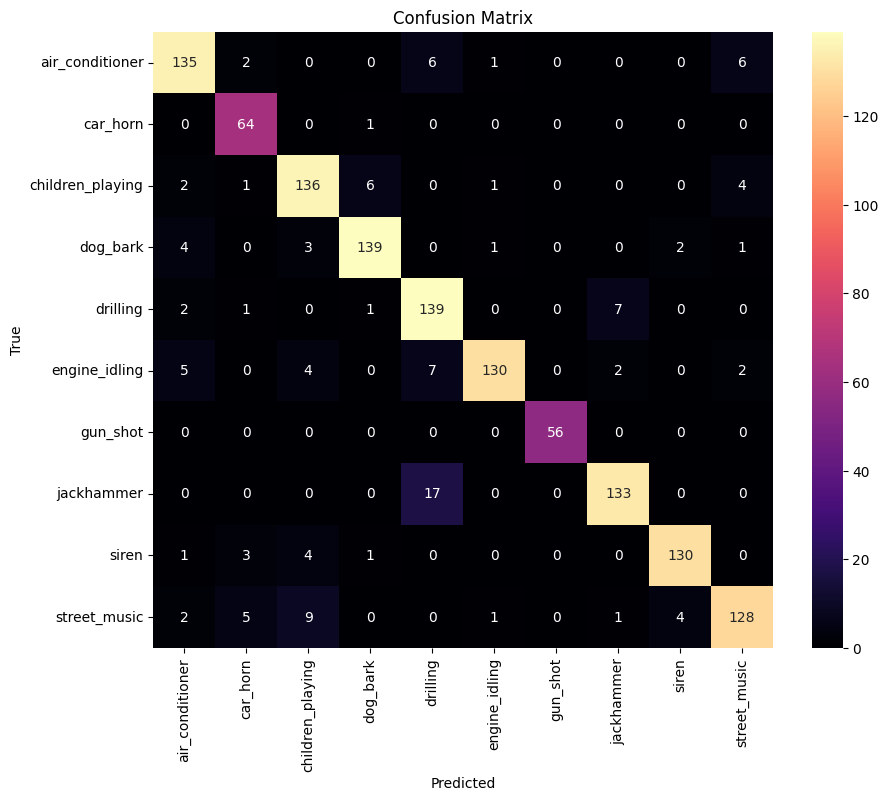

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="magma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

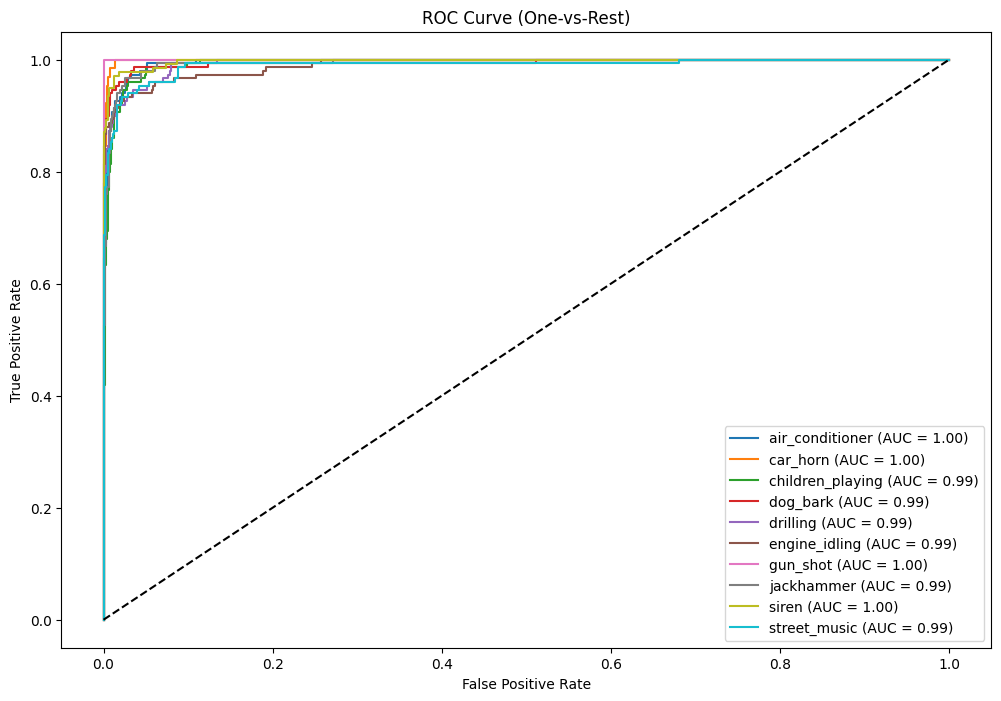

In [56]:
# ----------------------------------
# ROC y AUC (multiclase One-vs-Rest)
# ----------------------------------
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar etiquetas para multiclase
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_prob = np.array(y_prob)

plt.figure(figsize=(12,8))

# ROC por cada clase
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Baseline
plt.plot([0, 1], [0, 1], "k--")

plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [57]:
# AUC macro y micro
from sklearn.metrics import roc_auc_score

auc_macro = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
auc_micro = roc_auc_score(y_true_bin, y_prob, average="micro", multi_class="ovr")

print("AUC Macro:", auc_macro)
print("AUC Micro:", auc_micro)

AUC Macro: 0.9947314557287343
AUC Micro: 0.9944415308613198


Explicación de todos los cambios solo para realizar el data augmentation

1. Corrección Masiva de Rutas en el DataFrame
El Problema: Aunque corregiste la variable inicial dataset_ruta, el archivo CSV (mel_metadata.csv) contenía una columna con las rutas absolutas antiguas (D:\Documentos\IPN\...). TensorFlow leía estas rutas viejas fila por fila, causando un FileNotFoundError al intentar cargar los archivos .npy.

La Solución: Creamos un script que toma la columna spectrogram (la original del CSV), extrae solo el nombre del archivo y le pega la ruta correcta de tu disco actual (C:\Users\guill\OneDrive\...).

import os

# Nombre de la columna original detectada en tu CSV
nombre_columna = 'spectrogram' 

# Ruta real actual donde viven tus archivos .npy
ruta_espectrogramas = os.path.join(dataset_ruta, "espectrogramas")

def corregir_ruta(path_antiguo):
    try:
        # Extrae solo el nombre (ej: 1323-5-0.npy) ignorando la ruta vieja
        nombre_archivo = os.path.basename(str(path_antiguo))
        # Construye la ruta nueva válida
        return os.path.join(ruta_espectrogramas, nombre_archivo)
    except Exception as e:
        return path_antiguo

# Generamos la columna 'mel_path' estandarizada que usará todo el código
df_mel['mel_path'] = df_mel[nombre_columna].apply(corregir_ruta)

2. Estandarización de Etiquetas (Texto a Número)
El Problema: Tu código original usaba StringLookup dentro de la función de carga (tf_load_mel). Esto hacía que el proceso fuera opaco y difícil de depurar. Además, al dividir los datos (train_test_split), no tenías una columna numérica para usar stratify correctamente.

La Solución: Convertimos las etiquetas de texto (dog_bark) a números enteros (3) directamente en el DataFrame antes de crear el dataset.

Código Implementado:


 ---# Diccionario oficial de UrbanSound8K
label_map = {
    'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2,
    'dog_bark': 3, 'drilling': 4, 'engine_idling': 5,
    'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9
}

 ---# Crear columna 'label' numérica
if 'label' not in df_mel.columns:
    df_mel['label'] = df_mel['class_name'].map(label_map)

3. Reingeniería de las Funciones de Aumento (Data Augmentation)
El Problema: Al ejecutar augment_mel, obtenías errores de dimensiones (Shapes must be equal rank... o Dimension 3 ... are 1 and 128).

Las funciones como time_shift usaban vectores para el desplazamiento en lugar de escalares, provocando Broadcasting (inflaban la imagen de 1 canal a 128 canales).

Las máscaras (mask) calculaban mal las dimensiones si entraba un lote (batch) en lugar de una sola imagen.

La Solución: Blindamos las funciones para asegurar que siempre trabajen con formas fijas (128, 128, 1) y usen escalares para los parámetros aleatorios.

Código Clave (Ejemplo en time_shift y augment_mel):

def time_shift(mel, max_shift=10):
    -# CORRECCIÓN: shape=[] asegura que el shift sea un solo número (escalar)
    shift = tf.random.uniform(shape=[], minval=-max_shift, maxval=max_shift, dtype=tf.int32)
    return tf.roll(mel, shift=shift, axis=1)

def augment_mel(mel, label):
    input_shape = [128, 128, 1] 
    mel.set_shape(input_shape) # Ayuda a TF a no perder la forma
    
    -# Aplicación de aumentos
    mel = time_mask(mel, max_mask=15)
    mel = freq_mask(mel, max_mask=15)
    mel = random_gain(mel)
    mel = time_shift(mel, max_shift=8)

   -# CORRECCIÓN CRÍTICA: Reshape explícito para eliminar canales fantasma
    mel = tf.reshape(mel, input_shape)
    return mel, label

4. Reordenamiento de la Tubería (Pipeline) de TensorFlow
El Problema: Intentabas aplicar el aumento de datos (.map(augment_mel)) después de haber creado lotes (.batch(32)). Tus funciones de aumento esperaban una sola imagen (3D), pero recibían un paquete de 32 (4D), rompiendo la lógica matemática.

La Solución: Definimos una función create_dataset que aplica el aumento imagen por imagen antes de empaquetarlas en lotes.

Código Implementado:

-def create_dataset(dataframe, is_training=False):
    *-# 1. Crear dataset base
    ds = tf.data.Dataset.from_tensor_slices((dataframe["mel_path"].values, dataframe["label"].values))
    ds = ds.map(load_mel_only, num_parallel_calls=tf.data.AUTOTUNE)
    
    -# 2. Aumentar DATOS (Solo si es training y ANTES del batch)
    if is_training:
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.map(augment_mel, num_parallel_calls=tf.data.AUTOTUNE) # <-- Aquí ocurre la magia
    else:
        ds = ds.cache()

    *-# 3. Crear Batch al final
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

5. Regeneración de Datasets (Train, Val y Test)
El Problema: Al corregir las rutas en el DataFrame df_mel, los datasets train_ds y test_ds antiguos seguían "vivos" en la memoria de Python apuntando a las rutas viejas o sin la estructura correcta. Esto causaba errores al visualizar o al predecir (FileNotFoundError en el bloque de predicción).

La Solución: Fue necesario volver a ejecutar la división (train_test_split) y llamar a create_dataset para refrescar todo con la información limpia.

Código de Regeneración Final (Para Test):

-# Refrescar la división para asegurar que test_df tenga la columna 'mel_path'
train_df, test_val_df = train_test_split(df_mel, test_size=0.3, stratify=df_mel["label"], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df["label"], random_state=42)

-# Crear de nuevo el dataset de prueba limpio
test_ds = create_dataset(test_df, is_training=False)